In [ ]:
import pandas as pd
from datetime import datetime
import seaborn as sns
from matplotlib.pyplot import figure
import cx_Oracle as oci


Comments for the head of regional...


In [ ]:
conn = oci.connect("PREDICTION_USER", "PREDICTION_USER", "150.1.1.39:1521/NPPS2")
cur = conn.cursor()

sql = "SELECT TO_CHAR(TO_DATE(A.SND_DAT, 'YYYYMMDD'), 'YYYY-MM-DD HH:MI') AS \"datetime\" \
     , C.SEASON AS \"season\" \
     , CASE WHEN B.HOLIDAY_FLG = 'Y' THEN 1 ELSE 0 END AS \"holiday\" \
     , C.TEMP_MAX as \"temp_max\" \
     , C.TEMP_MIN as \"temp_min\" \
     , C.RAIN_FALL as \"rainfall\" \
     , SUM(A.DLV_QTY) AS \"count\" \
  FROM TB_DATA A \
     , TB_CALENDAR B \
     , TB_TEMP C \
 WHERE A.SND_DAT BETWEEN '20220201' AND '20221231' \
   AND A.SND_CST_COD LIKE '2200%' \
   AND A.SND_DAT = B.DATE_YMD \
   AND A.SND_DAT = C.TEMP_DAT \
 GROUP BY A.SND_DAT, B.HOLIDAY_FLG, C.SEASON, C.TEMP_MAX, C.TEMP_MIN, C.RAIN_FALL \
 ORDER BY A.SND_DAT"

datas = pd.read_sql(sql=sql, con = conn)

print(datas)

             datetime  season  holiday  temp_max  temp_min  rainfall  count
0    2022-02-01 12:00       4        1       0.9      -2.7       1.7   2007
1    2022-02-01 12:00       4        0       0.9      -2.7       1.7   2007
2    2022-02-02 12:00       4        1       0.0      -6.0       0.0     96
3    2022-02-02 12:00       4        0       0.0      -6.0       0.0     96
4    2022-02-03 12:00       4        0       0.4      -6.9       0.0   2772
..                ...     ...      ...       ...       ...       ...    ...
661  2022-12-29 12:00       4        0       2.1      -7.8       0.0   2512
662  2022-12-30 12:00       4        0       2.3      -4.4       0.0   3122
663  2022-12-30 12:00       4        0       2.3      -4.4       0.0   3122
664  2022-12-31 12:00       4        0       2.1      -5.1       0.0   1014
665  2022-12-31 12:00       4        0       2.1      -5.1       0.0   1014

[666 rows x 7 columns]


In [ ]:
# df = pd.read_csv('kpp_train2.csv', encoding='EUC-KR')
df = datas

### Creating New Features

In [ ]:
df["date"] = df.datetime.apply(lambda x : x.split()[0])
df["year"] = df.datetime.apply(lambda x : x.split()[0].split("-")[0])
df["weekday"] = df.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
df["month"] = df.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

In [ ]:
df.head()

,datetime,season,holiday,temp_max,temp_min,rainfall,count,date,year,weekday,month
0,2022-02-01 12:00,4,1,0.9,-2.7,1.7,2007,2022-02-01,2022,1,2
1,2022-02-01 12:00,4,0,0.9,-2.7,1.7,2007,2022-02-01,2022,1,2
2,2022-02-02 12:00,4,1,0.0,-6.0,0.0,96,2022-02-02,2022,2,2
3,2022-02-02 12:00,4,0,0.0,-6.0,0.0,96,2022-02-02,2022,2,2
4,2022-02-03 12:00,4,0,0.4,-6.9,0.0,2772,2022-02-03,2022,3,2


### Data Imputation

1. Get rid of columns/rows with NA values
2. Impute using mean/median/mode depending on context
3. Build a simple prediction model to impute
4. Replace with 0

In [ ]:
from sklearn.ensemble import RandomForestRegressor

dfrain0 = df[df["rainfall"]==0]
print(dfrain0)
dfrainNot0 = df[df["rainfall"]!=0]
print(dfrainNot0)
rfModel_rain = RandomForestRegressor()
rainColumns = ["season","month","year"]
rfModel_rain.fit(dfrainNot0[rainColumns], dfrainNot0["rainfall"])

rain0Values = rfModel_rain.predict(X= dfrain0[rainColumns])
dfrain0["rainfall"] = rain0Values
df = dfrainNot0.append(dfrain0)
df.reset_index(inplace=True)
df.drop('index',inplace=True,axis=1)

             datetime  season  holiday  temp_max  temp_min  rainfall  count  \
2    2022-02-02 12:00       4        1       0.0      -6.0       0.0     96   
3    2022-02-02 12:00       4        0       0.0      -6.0       0.0     96   
4    2022-02-03 12:00       4        0       0.4      -6.9       0.0   2772   
5    2022-02-03 12:00       4        0       0.4      -6.9       0.0   2772   
6    2022-02-04 12:00       4        0      -0.7      -8.2       0.0   4710   
..                ...     ...      ...       ...       ...       ...    ...   
661  2022-12-29 12:00       4        0       2.1      -7.8       0.0   2512   
662  2022-12-30 12:00       4        0       2.3      -4.4       0.0   3122   
663  2022-12-30 12:00       4        0       2.3      -4.4       0.0   3122   
664  2022-12-31 12:00       4        0       2.1      -5.1       0.0   1014   
665  2022-12-31 12:00       4        0       2.1      -5.1       0.0   1014   

           date  year  weekday  month  
2    2022-0

C:\Users\LogisALL\AppData\Local\Temp\ipykernel_3240\1091110070.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfrain0["rainfall"] = rain0Values
C:\Users\LogisALL\AppData\Local\Temp\ipykernel_3240\1091110070.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = dfrainNot0.append(dfrain0)


In [ ]:
df.head()

,datetime,season,holiday,temp_max,temp_min,rainfall,count,date,year,weekday,month
0,2022-02-01 12:00,4,1,0.9,-2.7,1.7,2007,2022-02-01,2022,1,2
1,2022-02-01 12:00,4,0,0.9,-2.7,1.7,2007,2022-02-01,2022,1,2
2,2022-02-14 12:00,4,0,8.1,-1.3,1.7,2713,2022-02-14,2022,0,2
3,2022-02-14 12:00,4,0,8.1,-1.3,1.7,2713,2022-02-14,2022,0,2
4,2022-02-19 12:00,4,0,3.7,-6.2,0.1,714,2022-02-19,2022,5,2


### Dealing with non-numerical Data

In [ ]:
categoricalFeatureNames = ["season","holiday","weekday", "month", "year"]
numericalFeatureNames = ["temp_max","temp_min","rainfall"]
dropFeatures = ["count", "datetime", "date"]
for var in categoricalFeatureNames:
  df[var] = df[var].astype("category")

## Model Training

At this point we have a good idea of what our data and features look like. Next thing we need to know is how well does our model need to perform.

### Splitting into training and test set

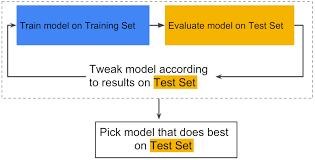

In [ ]:
#Dealing with non-numerical Data
categoricalFeatureNames = ["season","holiday","weekday", "month", "year"]
numericalFeatureNames = ["temp_max","temp_min","rainfall"]
dropFeatures = ["count", "datetime", "date"]
for var in categoricalFeatureNames:
  df[var] = df[var].astype("category")

In [ ]:
#Splitting Data into Train and Test
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

C:\Users\LogisALL\AppData\Local\Temp\ipykernel_3240\1824308707.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train["count"])


<AxesSubplot: xlabel='count', ylabel='Density'>

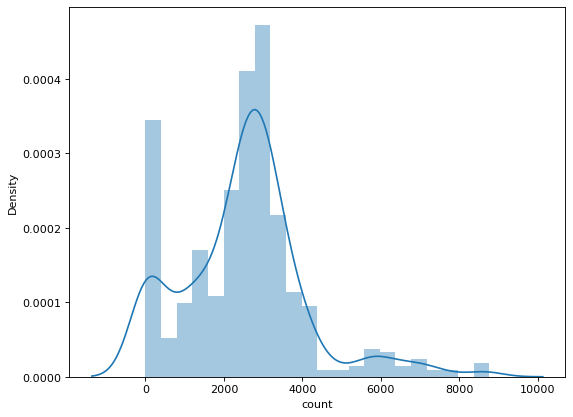

In [ ]:
#Visualizing Data
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
sns.distplot(train["count"])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

<AxesSubplot: >

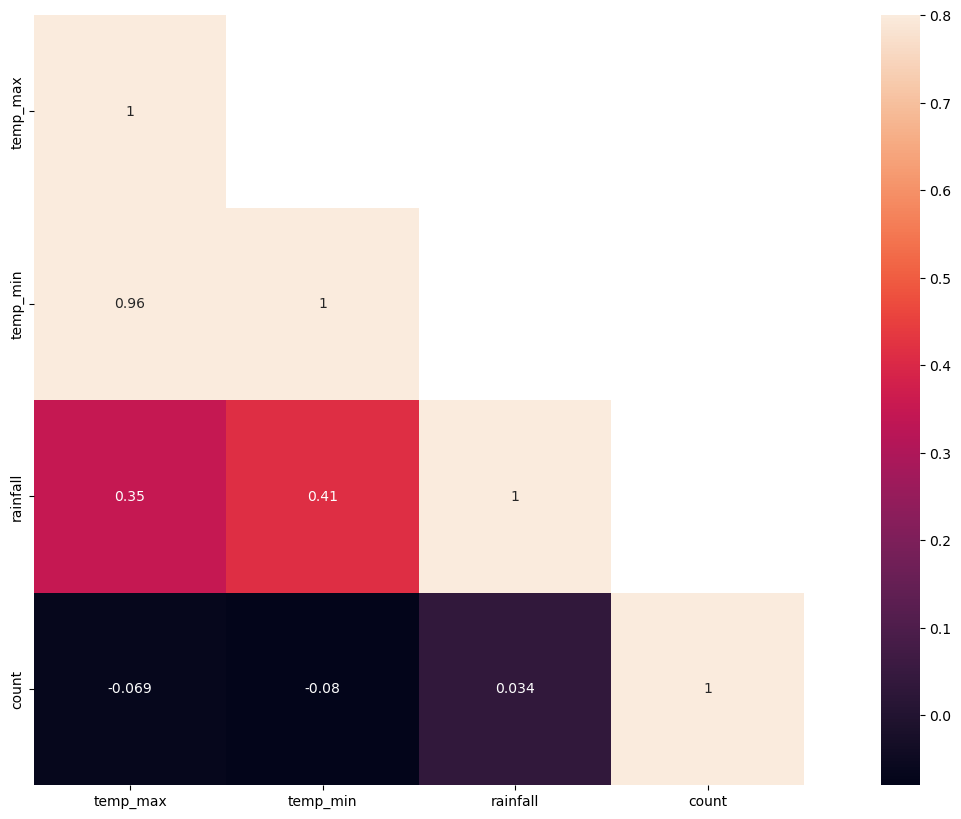

In [ ]:
#Correlation Matrix
corrMatt = train[["temp_max","temp_min","rainfall","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()

fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

In [ ]:
#Feature Selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [ ]:
featureNames = ["season","holiday","weekday", "month", "year","temp_max","temp_min","rainfall"]
X_train = train[featureNames]
y_train = train["count"]
X_test = test[featureNames]
y_test = test["count"]

rfModel = RandomForestRegressor()
rfModel.fit(X_train, y_train)

print("Score = ", rfModel.score(X_test, y_test))

Score =  0.9538824711678554


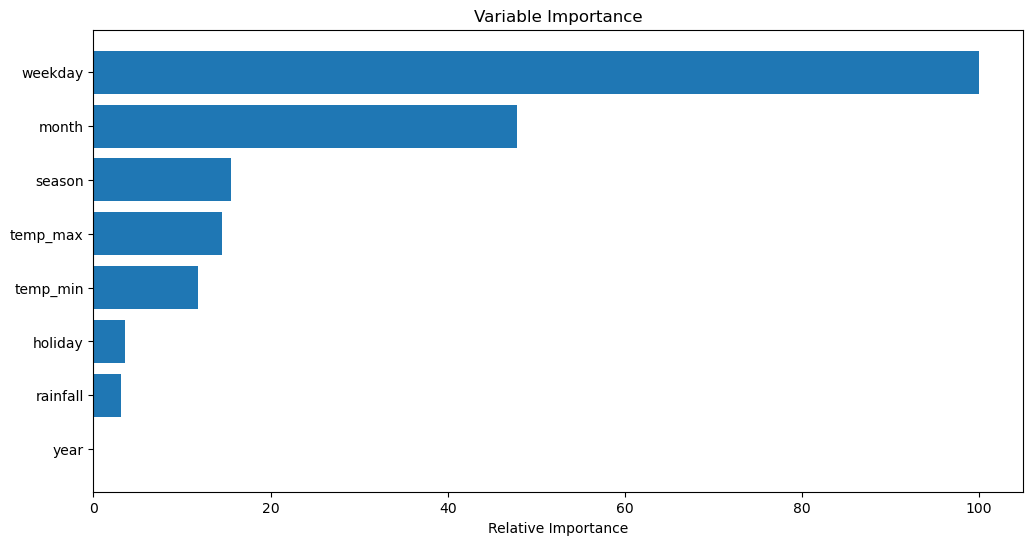

In [ ]:
#Feature Importance
featureImportance = rfModel.feature_importances_
featureImportance = 100.0 * (featureImportance / featureImportance.max())
sorted_idx = np.argsort(featureImportance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12,6))
plt.barh(pos, featureImportance[sorted_idx], align='center')
plt.yticks(pos, np.asanyarray(featureNames)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
#Model Development
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

rfModel = RandomForestRegressor(n_estimators=1000)
rfModel.fit(X_train, y_train)
preds = rfModel.predict(X=X_test)
print("Score = ", rfModel.score(X_test, y_test))

Score =  0.9561775257504052


In [ ]:
#RMSLE Evaluation
def rmsle(y, y_, convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [ ]:
#Model Evaluation
print("RMSLE Value For Random Forest: ",rmsle(np.exp(y_test), np.exp(preds), False))

RMSLE Value For Random Forest:  inf


c:\Program Files\Orange\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\LogisALL\AppData\Local\Temp\ipykernel_3240\2225598318.py:2: RuntimeWarning: overflow encountered in exp
  print("RMSLE Value For Random Forest: ",rmsle(np.exp(y_test), np.exp(preds), False))
C:\Users\LogisALL\AppData\Local\Temp\ipykernel_3240\2677541975.py:8: RuntimeWarning: overflow encountered in square
  calc = (log1 - log2) ** 2


C:\Users\LogisALL\AppData\Local\Temp\ipykernel_3240\1074783457.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, ax=ax1, bins=50)
C:\Users\LogisALL\AppData\Local\Temp\ipykernel_3240\1074783457.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preds, ax=ax2, bins=50)


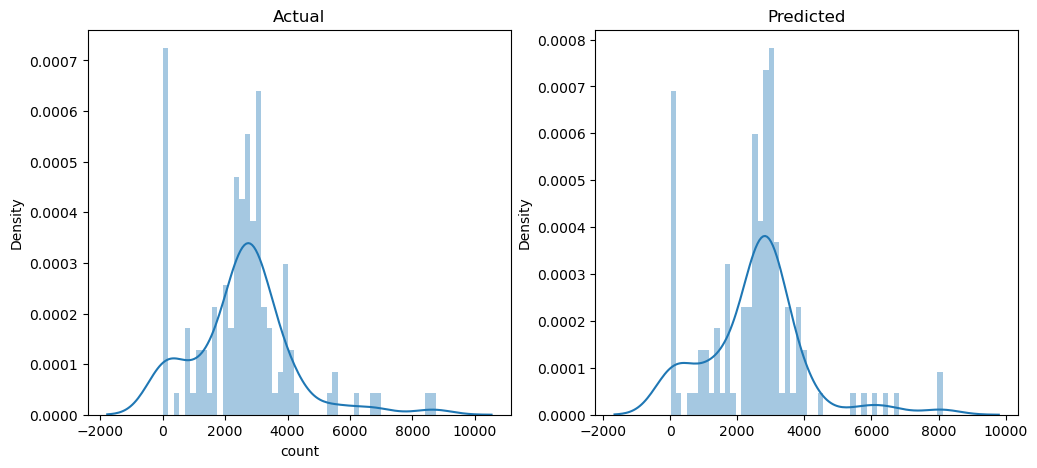

In [ ]:
#모델 예측 시각화
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(y_test, ax=ax1, bins=50)
ax1.set(title="Actual")
sns.distplot(preds, ax=ax2, bins=50)
ax2.set(title="Predicted")
plt.show()

C:\Users\LogisALL\AppData\Local\Temp\ipykernel_3240\24108466.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test,ax=ax1,bins=50)
C:\Users\LogisALL\AppData\Local\Temp\ipykernel_3240\24108466.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predsTest,ax=ax2,bins=50)


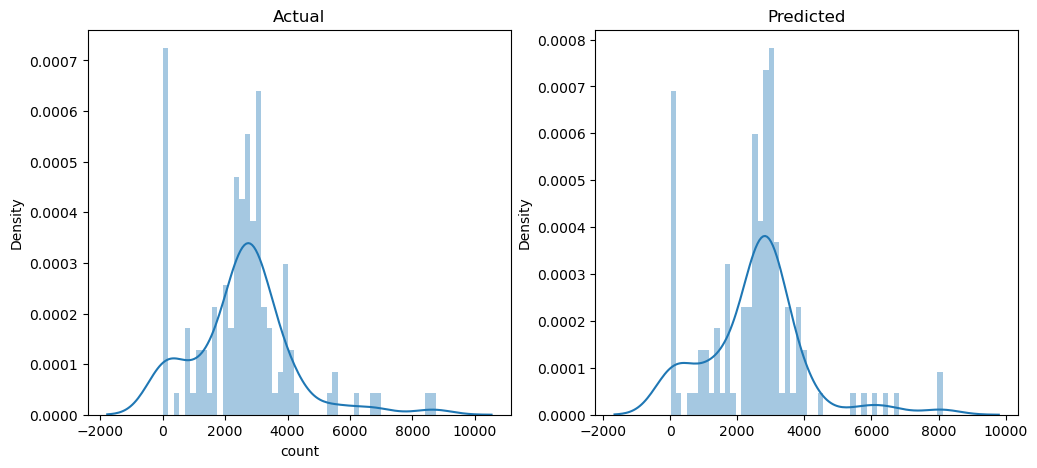

In [ ]:
#모델 예측 결과
predsTest = rfModel.predict(X=test[featureNames])
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_test,ax=ax1,bins=50)
ax1.set(title="Actual")
sns.distplot(predsTest,ax=ax2,bins=50)
ax2.set(title="Predicted")
plt.show()

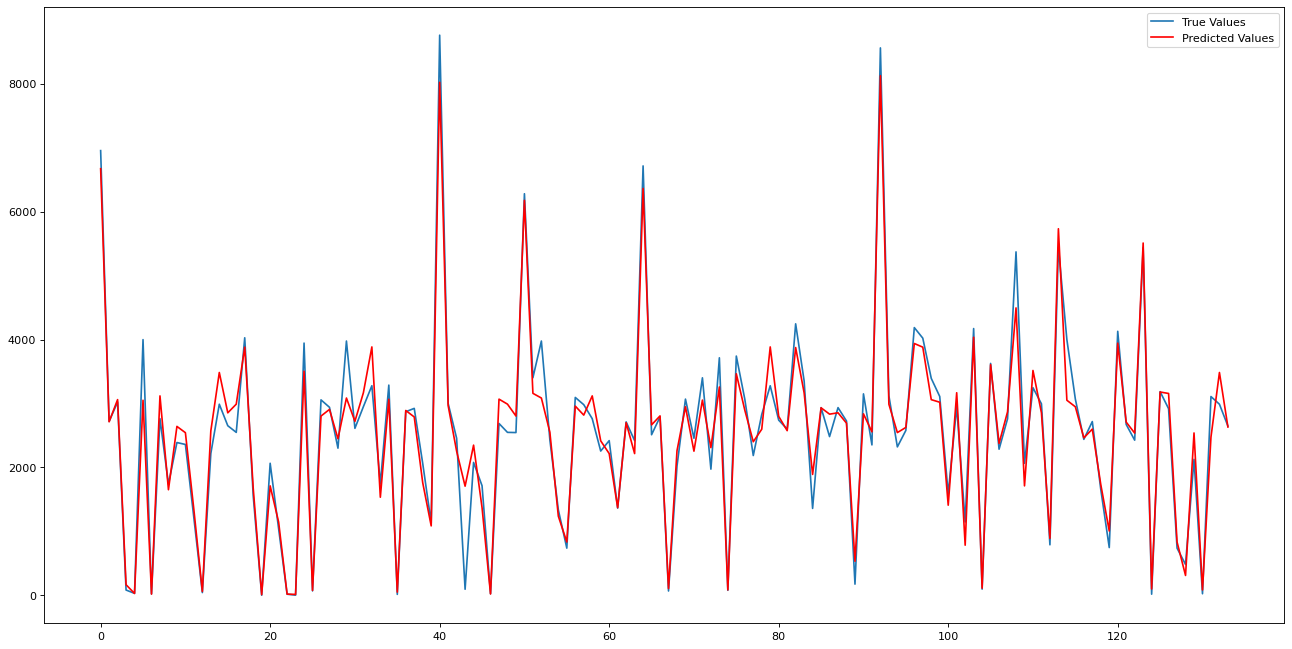

In [ ]:
from matplotlib import pyplot as plt
figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')

view_number=200
index = [x for x in range(len(y_test))]
plt.plot(y_test.values[-view_number:], label='True Values')
plt.plot(predsTest[-view_number:], c='r', label='Predicted Values')
plt.legend()

In [ ]:
#save model
import pickle
with open('prediction_model.pkl', 'wb') as f:
    pickle.dump(rfModel, f)

(remember to cover misc questions)

1. How and where can I use machine learning in supply chain plannning and management?
2. how much should we learn or what extent that we master in machine learning can make us get a job in data science
3. machine learning‘s specific and now-in-use application in supply chain
4. The applications of Machine Learning in Supply Chain field as well as the new trending (or outlook). 
5. What are the most frequently used ML algorithm in industry/work?
6. What kind of skills do I need
7. What skills are considered for a data science job? How much would your degree matter?
8. What the pre requirements before learning machine learning? (eg. Are there any necessary skills to master before learning Machine Learning?)
9. Which industries can use Machine Learning?